# Link Prediction in NetworKit

In this notebook, the usage of the link prediction module will be demonstrated.

1) Load NetworKit module as well as external modules (e.g. for supervised approaches)

In [27]:
from networkit import linkprediction as lp, readGraph, Format
# Needed to draw plots
%matplotlib inline
import matplotlib.pyplot as plt 
# Machine learning
from sklearn import *

In [2]:
cd ../../

/home/xza/Thesis/NetworKit-Esders


2) Helper function to draw ROC curve in the notebook

In [12]:
def drawROC(indexName, fpr, tpr):
    plt.suptitle(indexName, fontsize=18, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("False positive rate", fontsize=18)
    plt.ylabel("True positive rate", fontsize=18)
    plt.axis([0, 1, 0, 1])
    curve, = plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'grey', ls='--')
def drawUnsupervisedROC(indexName, predictions):
    fpr, tpr = roc.getCurve(predictions)
    drawROC(indexName, fpr, tpr)
def drawSupervisedROC(indexName, predictions, testLabels):
    predictionLabels = [p[1] for p in predictions]
    fpr, tpr, thresholds = metrics.roc_curve(testLabels, predictionLabels)
    drawROC(indexName, fpr, tpr)

3) Load an actual network that should be analyzed

In [4]:
testGraph = readGraph("input/CA-CondMat_tab-sep.edgelist", Format.EdgeListTabOne)
print("Loaded cond-mat with", testGraph.numberOfEdges(), "edges.")

Loaded cond-mat with 93497 edges.


4) Initialize ROC/PR metrics for testGraph

In [5]:
roc = lp.ROCMetric(testGraph)
pr = lp.PrecisionRecallMetric(testGraph)

5) Generate training and feature graphs

In [6]:
trainingGraph = lp.RandomLinkSampler.byPercentage(testGraph, 0.9)
print("Left out", testGraph.numberOfEdges() - trainingGraph.numberOfEdges(), "edges from test graph")
featureGraph = lp.RandomLinkSampler.byPercentage(trainingGraph, 0.7)
print("Left out", trainingGraph.numberOfEdges() - featureGraph.numberOfEdges(), "edges from training graph")

Left out 9350 edges from test graph
Left out 25245 edges from training graph


6) Initialize similarity indices

In [7]:
featureCommonNeighborsIndex = lp.CommonNeighborsIndex(featureGraph)
featureJaccardIndex = lp.JaccardIndex(featureGraph)
featurePreferentialAttachmentIndex = lp.PreferentialAttachmentIndex(featureGraph)
featureAdamicAdarIndex = lp.AdamicAdarIndex(featureGraph)
featureUDegreeIndex = lp.UDegreeIndex(featureGraph)
featureVDegreeIndex = lp.VDegreeIndex(featureGraph)
featureAlgebraicDistanceIndex = lp.AlgebraicDistanceIndex(featureGraph, 5, 15)
featureAlgebraicDistanceIndex.preprocess()
featureNeighborhoodDistanceIndex = lp.NeighborhoodDistanceIndex(featureGraph)
featureTotalNeighborsIndex = lp.TotalNeighborsIndex(featureGraph)
featureNeighborsMeasureIndex = lp.NeighborsMeasureIndex(featureGraph)
featureSameCommunityIndex = lp.SameCommunityIndex(featureGraph)
featureAdjustedRandIndex = lp.AdjustedRandIndex(featureGraph)
featureResourceAllocationIndex = lp.ResourceAllocationIndex(featureGraph)

commonNeighborsIndex = lp.CommonNeighborsIndex(trainingGraph)
jaccardIndex = lp.JaccardIndex(trainingGraph)
preferentialAttachmentIndex = lp.PreferentialAttachmentIndex(trainingGraph)
adamicAdarIndex = lp.AdamicAdarIndex(trainingGraph)
uDegreeIndex = lp.UDegreeIndex(trainingGraph)
vDegreeIndex = lp.VDegreeIndex(trainingGraph)
algebraicDistanceIndex = lp.AlgebraicDistanceIndex(trainingGraph, 5, 15)
algebraicDistanceIndex.preprocess()
neighborhoodDistanceIndex = lp.NeighborhoodDistanceIndex(trainingGraph)
totalNeighborsIndex = lp.TotalNeighborsIndex(trainingGraph)
neighborsMeasureIndex = lp.NeighborsMeasureIndex(trainingGraph)
sameCommunityIndex = lp.SameCommunityIndex(trainingGraph)
adjustedRandIndex = lp.AdjustedRandIndex(trainingGraph)
resourceAllocationIndex = lp.ResourceAllocationIndex(trainingGraph)

featureLinkPredictors = (featureCommonNeighborsIndex, featureJaccardIndex, featureAdamicAdarIndex, featurePreferentialAttachmentIndex, featureUDegreeIndex, featureVDegreeIndex, featureAlgebraicDistanceIndex, featureNeighborhoodDistanceIndex, featureTotalNeighborsIndex, featureNeighborsMeasureIndex, featureSameCommunityIndex, featureResourceAllocationIndex, featureAdjustedRandIndex)
linkPredictors = (commonNeighborsIndex, jaccardIndex, adamicAdarIndex, preferentialAttachmentIndex, uDegreeIndex, vDegreeIndex, algebraicDistanceIndex, neighborhoodDistanceIndex, totalNeighborsIndex, neighborsMeasureIndex, sameCommunityIndex, resourceAllocationIndex, adjustedRandIndex)

7) Generate testing and training sets

In [8]:
trainingSet = lp.MissingLinksFinder(featureGraph).findAtDistance(2)
testingSet = lp.MissingLinksFinder(trainingGraph).findAtDistance(2)

labelTrain = lp.getLabels(trainingSet, trainingGraph)
featureTrain = lp.getFeatures(trainingSet, *featureLinkPredictors)

labelTest = lp.getLabels(testingSet, testGraph)
featureTest = lp.getFeatures(testingSet, *linkPredictors)

print("Training set size:", len(trainingSet))
print("Testing set size:", len(testingSet))

Training set size: 695563
Testing set size: 977160


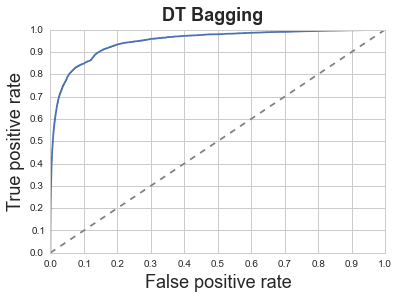

In [13]:
# Create and train classifier
dtc = ensemble.BaggingClassifier(n_estimators=25, max_features=0.2, n_jobs=-1)
dtc.fit(featureTrain, labelTrain)
# Actual prediction
predictions = dtc.predict_proba(featureTest)
drawSupervisedROC("DT Bagging", predictions, labelTest)

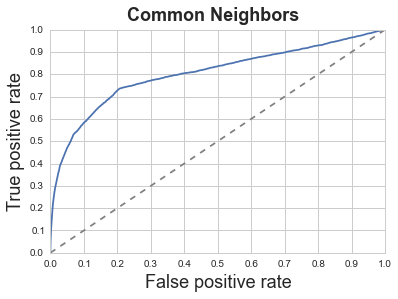

In [26]:
cnPreds = commonNeighborsIndex.runOn(testingSet)
drawUnsupervisedROC("Common Neighbors", cnPreds)

In [30]:
lp.LinkThresholder.byCount(cnPreds, 10)

[(8099, 101742),
 (12452, 66304),
 (12452, 75079),
 (23613, 90983),
 (33734, 75079),
 (36302, 66304),
 (39924, 90983),
 (51635, 78103),
 (52657, 101424),
 (68723, 99114)]